### Importar librerías

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install comet_ml
!pip install tensorflow_addons

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
import os
import zipfile
from comet_ml import Experiment

# Path Franco
path_base = '/content/drive/MyDrive/TAA/retinopatia_entrenamiento'

# Path Guille
path_base = '/content/drive/MyDrive/Facultad'
path_base = '/content/drive/MyDrive/FACULTAD/TAA'

# Path taa
# path_base = '/content/drive/MyDrive'

### Manejo de datos

In [ ]:
# ============================== #
# Rutas de los archivos TFRecord #
# ============================== #

path_carpeta_tfr = os.path.join(path_base, 'tf_records')
tfr_paths = os.listdir(path_carpeta_tfr)

paths_completos = [path_carpeta_tfr + '/' + i for i in tfr_paths]
print(f'Paths completos a los TFRecords: \n {paths_completos}')

Paths completos a los TFRecords: 
 ['/content/drive/MyDrive/FACULTAD/TAA/tf_records/train00-1536.tfrec', '/content/drive/MyDrive/FACULTAD/TAA/tf_records/train01-1536.tfrec', '/content/drive/MyDrive/FACULTAD/TAA/tf_records/train02-1536.tfrec', '/content/drive/MyDrive/FACULTAD/TAA/tf_records/train03-1536.tfrec', '/content/drive/MyDrive/FACULTAD/TAA/tf_records/train04-1536.tfrec', '/content/drive/MyDrive/FACULTAD/TAA/tf_records/train05-1536.tfrec', '/content/drive/MyDrive/FACULTAD/TAA/tf_records/train06-1536.tfrec', '/content/drive/MyDrive/FACULTAD/TAA/tf_records/train07-1536.tfrec', '/content/drive/MyDrive/FACULTAD/TAA/tf_records/train08-1536.tfrec', '/content/drive/MyDrive/FACULTAD/TAA/tf_records/train09-1536.tfrec', '/content/drive/MyDrive/FACULTAD/TAA/tf_records/train10-1536.tfrec', '/content/drive/MyDrive/FACULTAD/TAA/tf_records/train11-1536.tfrec', '/content/drive/MyDrive/FACULTAD/TAA/tf_records/train12-1536.tfrec', '/content/drive/MyDrive/FACULTAD/TAA/tf_records/train13-1536.tfrec'

In [ ]:
# ============================================= #
# Funcion para presentar un ejemplo de TFRecord #
# ============================================= #

# Se disminuye el tamaño de la imagen para reducir los tiempos
# image_size = (240, 240)
image_size = (615, 900)


# Función para analizar un ejemplo de TF Record
def parse_tfr_element(element):
    data = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'eye': tf.io.FixedLenFeature([], tf.int64),
        'level_cat': tf.io.FixedLenFeature([], tf.int64),
    }
    content = tf.io.parse_single_example(element, data)

    # Decodificar la imagen de fondo de ojo
    image = tf.io.decode_jpeg(content['image'], channels=3)
    # image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, image_size)

    # Devolver los datos y la etiqueta
    return image, content['level_cat']

In [ ]:
# ================ #
# Crear el Dataset #
# ================ #

# Crear un dataset con todos los archivos TF Record
dataset = tf.data.TFRecordDataset(paths_completos)

dataset = dataset.map(parse_tfr_element)

# Cuenta elementos del ds
# count = 0
# for _ in dataset:
#     count += 1
# print("Cantidad de elementos de dataset:", count)

In [ ]:
# ======================== #
# Se divide en Train y Val #
# ======================== #

cant_datos = 35126
train_size = 28100

# cant_datos = 1536
# train_size = 1228

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# Se dividen los datos en batches
Xy_train = train_dataset.batch(32)
Xy_val = val_dataset.batch(32)

In [ ]:
# Cuenta elementos del ds
count = 0
for _ in Xy_train:
    count += 1
print("Cantidad de elementos de dataset:", count)

In [ ]:
# Cuenta elementos del ds
count = 0
for _ in Xy_val:
    count += 1
print("Cantidad de elementos de dataset:", count)

Cantidad de elementos de dataset: 220


### Metricas

In [ ]:
# ======================= #
# Funcion para la metrica #
# ======================= #

from sklearn.metrics import cohen_kappa_score
import tensorflow_addons as tfa
from tensorflow_addons.metrics import CohenKappa


kappa = tfa.metrics.CohenKappa(num_classes=5, weightage='quadratic', sparse_labels=True)

# Modelos

### 1) Resnet50

In [ ]:
# ================================= #
# Modelo preentrenado con Resnet 50 #
# ================================= #

def make_resnet50_model():

    # Definir la entrada del modelo
    input_tensor = tf.keras.Input(shape=(240, 240, 3))
    input_tensor = data_augmentation(input_tensor)  # Apply random data augmentation

    # Cargar el modelo ResNet50 pre-entrenado
    resnet_model = keras.applications.resnet50.ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=(240, 240, 3),
        input_tensor=input_tensor
    )

    # Congelar las primeras capas del modelo ResNet50
    for layer in resnet_model.layers[:143]:
        layer.trainable = False

    # Agregar capas adicionales utilizando el enfoque funcional
    x = resnet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    output = tf.keras.layers.Dense(5, activation='softmax')(x)

    # Definir el modelo final
    model = tf.keras.Model(inputs=resnet_model.input, outputs=output)
    optimizador = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizador,
                  metrics=["sparse_categorical_accuracy", kappa])

    return model

In [ ]:
# Capas de la red #

# model_rn50 = make_resnet50_model()

# for i, layer in enumerate(model_rn50.layers):
#   print(i, layer.name)

In [ ]:
# SE REGISTRAN LOS PARAMETROS UTILIZADOS
batch_size = 32
epochs = 20
learning_rate = 0.001
num_classes = 5

nombre_modelo = str(input('Insertar nombre del modelo para callback: '))
path_guardado = os.path.join(path_base, f'{nombre_modelo}/')

# Preprocesamiento de los datos de entrenamiento
Xy_train_preprocessed = Xy_train.map(lambda X, y: (keras.applications.resnet50.preprocess_input(X), y))

# Preprocesamiento de los datos de validación
Xy_val_preprocessed = Xy_val.map(lambda X, y: (keras.applications.resnet50.preprocess_input(X), y))

# ================== #
# SE LLAMA AL MODELO #
# ================== #
model_rn50 = make_resnet50_model()
# model_rn50.load_weights('/content/save_at_4.keras')
model_rn50.summary()

# Definir el callback ModelCheckpoint para guardar el modelo después de cada época
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath= path_guardado + "save_at_{epoch}.keras")]
history_prueba = model_rn50.fit(Xy_train_preprocessed, epochs=epochs, callbacks=callbacks, validation_data=(Xy_val_preprocessed))

# SE REGISTRA LA LOSS Y LAS METRICAS UTILIZADAS EN EL MODELO
loss_train, accuracy_train, quadratic_kappa_train = model_rn50.evaluate(Xy_train_preprocessed)
loss_val, accuracy_val, quadratic_kappa_val = model_rn50.evaluate(Xy_val_preprocessed)
# loss_test, accuracy_test, quadratic_kappa_test = model_prueba.evaluate(X_test,y_test)

print(f"Train => Loss: {loss_train}, Accuracy: {accuracy_train}, Quadratic Weighted Kappa: {quadratic_kappa_train}")
print(f"Val => Loss: {loss_val}, Accuracy: {accuracy_val}, Quadratic Weighted Kappa: {quadratic_kappa_val}")
# print(f"Test => Loss: {loss_test}, Accuracy: {accuracy_test}, Quadratic Weighted Kappa: {quadratic_kappa_test}")


Insertar nombre del modelo para callback: resenet_143_capas
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 246, 246, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 120, 120, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                

In [ ]:
print(history_prueba.history)

{'loss': [1.0037089586257935, 0.9765737652778625], 'accuracy': [0.09914590418338776, 0.23224198818206787], 'cuadratic_cohen_kappa': [-0.004138047341257334, -0.01521433424204588], 'val_loss': [0.9895504117012024, 0.9724084138870239], 'val_accuracy': [0.17409253120422363, 0.4978291690349579], 'val_cuadratic_cohen_kappa': [-0.010142024606466293, -0.017971545457839966]}


#### Guardar modelo

In [ ]:
import joblib

joblib.dump(model_rn50, 'modelo_rn50_143capas.pkl')

['modelo_rn50_143capas.pkl']

### 2) Resnet50 + Data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
                                         tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
                                         tf.keras.layers.experimental.preprocessing.RandomContrast(0.2)
                                         ])

In [ ]:
# ================================================== #
# Modelo preentrenado resnet50 con Data augmentation #
# ================================================== #

def make_resnet50_data_aug_model():

    # Definir la entrada del modelo
    input_tensor = tf.keras.Input(shape=(240, 240, 3))
    #'unica diferencia con el modelo 1):'
    input_tensor = data_augmentation(input_tensor)  # Apply random data augmentation

    # Cargar el modelo ResNet50 pre-entrenado
    resnet_model = keras.applications.resnet50.ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=(240, 240, 3),
        input_tensor=input_tensor
    )

    # Congelar las primeras capas del modelo ResNet50
    for layer in resnet_model.layers[:143]:
        layer.trainable = False

    # Agregar capas adicionales utilizando el enfoque funcional
    x = resnet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    output = tf.keras.layers.Dense(5, activation='softmax')(x)

    # Definir el modelo final
    model = tf.keras.Model(inputs=resnet_model.input, outputs=output)
    optimizador = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizador,
                  metrics=["sparse_categorical_accuracy", kappa])

    return model

In [ ]:
# SE REGISTRAN LOS PARAMETROS UTILIZADOS
batch_size = 32
epochs = 20
learning_rate = 0.0001
num_classes = 5

nombre_modelo = str(input('Insertar nombre del modelo para callback: '))
path_guardado = os.path.join(path_base, f'{nombre_modelo}/')

# Preprocesamiento de los datos de entrenamiento
Xy_train_preprocessed = Xy_train.map(lambda X, y: (keras.applications.resnet50.preprocess_input(X), y))

# Preprocesamiento de los datos de validación
Xy_val_preprocessed = Xy_val.map(lambda X, y: (keras.applications.resnet50.preprocess_input(X), y))

# ================== #
# SE LLAMA AL MODELO #
# ================== #
model_rn50_data_aug = make_resnet50_data_aug_model()
# model_rn50_data_aug.load_weights('/content/save_at_4.keras')
model_rn50_data_aug.summary()

# Definir el callback ModelCheckpoint para guardar el modelo después de cada época
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath= path_guardado + "save_at_{epoch}.keras")]
history = model_rn50_data_aug.fit(Xy_train_preprocessed, epochs=epochs, callbacks=callbacks, validation_data=(Xy_val_preprocessed))

# SE REGISTRA LA LOSS Y LAS METRICAS UTILIZADAS EN EL MODELO
print('\n ==> Evaluando modelos ...')
loss_train, accuracy_train, quadratic_kappa_train = model_rn50_data_aug.evaluate(Xy_train_preprocessed)
loss_val, accuracy_val, quadratic_kappa_val = model_rn50_data_aug.evaluate(Xy_val_preprocessed)
# loss_test, accuracy_test, quadratic_kappa_test = model_prueba.evaluate(X_test,y_test)

print(f"Train => Loss: {loss_train}, Accuracy: {accuracy_train}, Quadratic Weighted Kappa: {quadratic_kappa_train}")
print(f"Val => Loss: {loss_val}, Accuracy: {accuracy_val}, Quadratic Weighted Kappa: {quadratic_kappa_val}")
# print(f"Test => Loss: {loss_test}, Accuracy: {accuracy_test}, Quadratic Weighted Kappa: {quadratic_kappa_test}")


Insertar nombre del modelo para callback: modelo_rn50_143capas_data_augmentation
94765736/94765736 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 240, 240, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 246, 246, 3)  0           ['sequential[0][0]']             
                                               

#### Guardar modelo

In [ ]:
import joblib

path_guardado = os.path.join(path_base, f'{nombre_modelo}.pkl')

joblib.dump(model_rn50_data_aug, path_guardado)

#'modelo_rn50_143capas_data_augmentation.pkl'

['/content/drive/MyDrive/Facultad/modelo_rn50_143capas_data_augmentation.pkl']

### 3) Resnet50 + Data augmentation + Class weights

In [ ]:
# calcular weights
# ver de normalizarlos (confirmar si deben sumar 1)

class_weights={0 : 0.27276257037468454,
               1 : 2.8658847526772053,
               2 : 1.31615925058548,
               3 : 7.937853107344632,
               4 : 10.089766606822263}

In [ ]:
# ================================================== #
# Modelo preentrenado resnet50 con Data augmentation #
# ================================================== #

def make_resnet50_data_aug_model_class_weights():

    # Definir la entrada del modelo
    input_tensor = tf.keras.Input(shape=(240, 240, 3))
    #'unica diferencia con el modelo 1):'
    input_tensor = data_augmentation(input_tensor)  # Apply random data augmentation

    # Cargar el modelo ResNet50 pre-entrenado
    resnet_model = keras.applications.resnet50.ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=(240, 240, 3),
        input_tensor=input_tensor
    )

    # Congelar las primeras capas del modelo ResNet50
    for layer in resnet_model.layers[:143]:
        layer.trainable = False

    # Agregar capas adicionales utilizando el enfoque funcional
    x = resnet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    output = tf.keras.layers.Dense(5, activation='softmax')(x)

    # Definir el modelo final
    model = tf.keras.Model(inputs=resnet_model.input, outputs=output)
    optimizador = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizador,
                  metrics=["sparse_categorical_accuracy", kappa])

    return model

In [ ]:
# SE REGISTRAN LOS PARAMETROS UTILIZADOS
batch_size = 32
epochs = 20
learning_rate = 0.0001
num_classes = 5

nombre_modelo = str(input('Insertar nombre del modelo para callback: '))
path_guardado = os.path.join(path_base, f'{nombre_modelo}/')

# Preprocesamiento de los datos de entrenamiento
Xy_train_preprocessed = Xy_train.map(lambda X, y: (keras.applications.resnet50.preprocess_input(X), y))

# Preprocesamiento de los datos de validación
Xy_val_preprocessed = Xy_val.map(lambda X, y: (keras.applications.resnet50.preprocess_input(X), y))

# ================== #
# SE LLAMA AL MODELO #
# ================== #
model_rn50_data_aug_class_weights = make_resnet50_data_aug_model_class_weights()
# make_resnet50_data_aug_model_class_weights.load_weights('/content/save_at_4.keras')
model_rn50_data_aug_class_weights.summary()

# Definir el callback ModelCheckpoint para guardar el modelo después de cada época
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath= path_guardado + "save_at_{epoch}.keras")]
history = model_rn50_data_aug_class_weights.fit(Xy_train_preprocessed, epochs=epochs, callbacks=callbacks, validation_data=(Xy_val_preprocessed), class_weight = class_weights
)

# SE REGISTRA LA LOSS Y LAS METRICAS UTILIZADAS EN EL MODELO
print('\n ==> Evaluando modelos ...')
loss_train, accuracy_train, quadratic_kappa_train = model_rn50_data_aug_class_weights.evaluate(Xy_train_preprocessed)
loss_val, accuracy_val, quadratic_kappa_val = model_rn50_data_aug_class_weights.evaluate(Xy_val_preprocessed)
# loss_test, accuracy_test, quadratic_kappa_test = model_prueba.evaluate(X_test,y_test)

print(f"Train => Loss: {loss_train}, Accuracy: {accuracy_train}, Quadratic Weighted Kappa: {quadratic_kappa_train}")
print(f"Val => Loss: {loss_val}, Accuracy: {accuracy_val}, Quadratic Weighted Kappa: {quadratic_kappa_val}")
# print(f"Test => Loss: {loss_test}, Accuracy: {accuracy_test}, Quadratic Weighted Kappa: {quadratic_kappa_test}")


Insertar nombre del modelo para callback: rn50_143_data_aug_class_weights
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, None, None,   0           ['input_5[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 246, 246, 3)  0           ['sequential_1[2][0]']           
                  

#### Guardar modelo

In [ ]:
path_guardado = os.path.join(path_base, f'{nombre_modelo}.pkl')

joblib.dump(model_rn50_data_aug, path_guardado)

#'modelo_rn50_143capas_data_augmentation.pkl'

##

### 4) Resnet50 + Resolution

In [ ]:
# para este modelo: definir tamaño de la imagen al principio.
# chequear el tamaño de la imagen:
image_size = (500,500)
print('tamaño a utilizar: ',image_size)

tamaño a utilizar:  (500, 500)


In [ ]:
# ================================================== #
# Modelo preentrenado resnet50 con Data augmentation #
# ================================================== #

def make_resnet50_resolution_model():

    # Definir la entrada del modelo
    input_tensor = tf.keras.Input(shape=(500, 500, 3))

    # Cargar el modelo ResNet50 pre-entrenado
    resnet_model = keras.applications.resnet50.ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=(500, 500, 3),
        input_tensor=input_tensor
    )

    # Congelar las primeras capas del modelo ResNet50
    for layer in resnet_model.layers[:143]:
        layer.trainable = False

    # Agregar capas adicionales utilizando el enfoque funcional
    x = resnet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    output = tf.keras.layers.Dense(5, activation='softmax')(x)

    # Definir el modelo final
    model = tf.keras.Model(inputs=resnet_model.input, outputs=output)

    optimizador = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizador,
                  metrics=["sparse_categorical_accuracy", kappa])

    return model

In [ ]:
# SE REGISTRAN LOS PARAMETROS UTILIZADOS
batch_size = 32
epochs = 20
learning_rate = 0.0001
num_classes = 5

nombre_modelo = str(input('Insertar nombre del modelo para callback: '))
path_guardado = os.path.join(path_base, f'{nombre_modelo}/')

# Preprocesamiento de los datos de entrenamiento
Xy_train_preprocessed = Xy_train.map(lambda X, y: (keras.applications.resnet50.preprocess_input(X), y))

# Preprocesamiento de los datos de validación
Xy_val_preprocessed = Xy_val.map(lambda X, y: (keras.applications.resnet50.preprocess_input(X), y))

# ================== #
# SE LLAMA AL MODELO #
# ================== #
model_rn50_resolution = make_resnet50_resolution_model()
# model_rn50_resolution.load_weights('/content/save_at_4.keras')
model_rn50_resolution.summary()

# Definir el callback ModelCheckpoint para guardar el modelo después de cada época
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath= path_guardado + "save_at_{epoch}.keras"),
             tf.keras.callbacks.ModelCheckpoint(filepath= path_guardado + "BestModel_at_{epoch}.keras", monitor = 'val_cohen_kappa', save_best_only = True)]

history = model_rn50_resolution.fit(Xy_train_preprocessed, epochs=epochs, callbacks=callbacks, validation_data=(Xy_val_preprocessed))

# SE REGISTRA LA LOSS Y LAS METRICAS UTILIZADAS EN EL MODELO
print('\n ==> Evaluando modelos ...')
loss_train, accuracy_train, quadratic_kappa_train = model_rn50_resolution.evaluate(Xy_train_preprocessed)
loss_val, accuracy_val, quadratic_kappa_val = model_rn50_resolution.evaluate(Xy_val_preprocessed)
# loss_test, accuracy_test, quadratic_kappa_test = model_rn50_resolution.evaluate(X_test,y_test)

print(f"Train => Loss: {loss_train}, Accuracy: {accuracy_train}, Quadratic Weighted Kappa: {quadratic_kappa_train}")
print(f"Val => Loss: {loss_val}, Accuracy: {accuracy_val}, Quadratic Weighted Kappa: {quadratic_kappa_val}")
# print(f"Test => Loss: {loss_test}, Accuracy: {accuracy_test}, Quadratic Weighted Kappa: {quadratic_kappa_test}")

In [ ]:
# =========================================================== #
# Celda para continuar entrenamiento en la epoca que se cortó #
# =========================================================== #


from tensorflow.keras.models import load_model

path_guardado = os.path.join(path_base, 'rn50_143_resolution/')

# Cargar el modelo guardado en la época 14
modelo_guardado = os.path.join(path_guardado, "save_at_14.keras")
model_rn50_resolution = load_model(modelo_guardado)

# Definir el callback ModelCheckpoint para guardar el modelo después de cada época
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=path_guardado + "save_at_{epoch}.keras")]

# Continuar el entrenamiento desde la época
history_resolution = model_rn50_resolution.fit(Xy_train_preprocessed, epochs=epochs, initial_epoch=14, callbacks=callbacks, validation_data=Xy_val_preprocessed)

Epoch 15/20
879/879 [==============================] - 972s 1s/step - loss: 0.0455 - sparse_categorical_accuracy: 0.9844 - cohen_kappa: 0.9827 - val_loss: 1.7355 - val_sparse_categorical_accuracy: 0.7983 - val_cohen_kappa: 0.6767
Epoch 16/20
879/879 [==============================] - 874s 994ms/step - loss: 0.0418 - sparse_categorical_accuracy: 0.9858 - cohen_kappa: 0.9830 - val_loss: 1.3145 - val_sparse_categorical_accuracy: 0.7899 - val_cohen_kappa: 0.6544
Epoch 17/20
879/879 [==============================] - 868s 986ms/step - loss: 0.0367 - sparse_categorical_accuracy: 0.9880 - cohen_kappa: 0.9846 - val_loss: 1.5781 - val_sparse_categorical_accuracy: 0.7780 - val_cohen_kappa: 0.6724
Epoch 18/20
879/879 [==============================] - 870s 988ms/step - loss: 0.0352 - sparse_categorical_accuracy: 0.9879 - cohen_kappa: 0.9859 - val_loss: 1.4129 - val_sparse_categorical_accuracy: 0.7444 - val_cohen_kappa: 0.6426
Epoch 19/20
879/879 [==============================] - 864s 983ms/step 

#### Guardar modelo

In [ ]:
import joblib

path_guardado = os.path.join(path_base, 'rn50_143_resolution.pkl')

joblib.dump(model_rn50_resolution, path_guardado)

#'modelo_rn50_143capas_data_augmentation.pkl'

['/content/drive/MyDrive/rn50_143_resolution.pkl']

### 5) Resnet50 + Data augmentation + Class weights + Resolution

comentario: para las primeras 10 epocas uso lr 10e-4, para las segundas 10 a 20 epocas: lr = 1e-5

In [ ]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                         tf.keras.layers.experimental.preprocessing.RandomRotation(0.1)
                                         ])

In [ ]:
# para este modelo: definir tamaño de la imagen al principio.
# chequear el tamaño de la imagen:
image_size = (500,500)
print('tamaño a utilizar: ',image_size)

tamaño a utilizar:  (500, 500)


In [ ]:
# calcular weights
# ver de normalizarlos (confirmar si deben sumar 1)

class_weights={0 : 0.27276257037468454,
               1 : 2.8658847526772053,
               2 : 1.31615925058548,
               3 : 7.937853107344632,
               4 : 10.089766606822263}

In [ ]:
# ================================================== #
# Modelo preentrenado resnet50 con Data augmentation #
# ================================================== #

def make_resnet50_data_aug_model_class_weights_resolution():

    # Definir la entrada del modelo
    input_tensor = tf.keras.Input(shape=(500, 500, 3))
    #'unica diferencia con el modelo 1):'
    input_tensor = data_augmentation(input_tensor)  # Apply random data augmentation

    # Cargar el modelo ResNet50 pre-entrenado
    resnet_model = keras.applications.resnet50.ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=(500, 500, 3),
        input_tensor=input_tensor
    )

    # Congelar las primeras capas del modelo ResNet50
    for layer in resnet_model.layers[:143]:
        layer.trainable = False

    # Agregar capas adicionales utilizando el enfoque funcional
    x = resnet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    output = tf.keras.layers.Dense(5, activation='softmax')(x)

    # Definir el modelo final
    model = tf.keras.Model(inputs=resnet_model.input, outputs=output)

    # Para la segunda tanda de epocas, uso 1e-5
    optimizador = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizador,
                  metrics=["sparse_categorical_accuracy", kappa])

    return model

In [ ]:
# =================================
# PRIMERAS 10 EPOCAS DEL MODELO.
# =================================

# SE REGISTRAN LOS PARAMETROS UTILIZADOS
batch_size = 32
epochs = 10
learning_rate = 0.0001
num_classes = 5

nombre_modelo = str(input('Insertar nombre del modelo para callback: '))
path_guardado = os.path.join(path_base, f'{nombre_modelo}/')

# Preprocesamiento de los datos de entrenamiento
Xy_train_preprocessed = Xy_train.map(lambda X, y: (keras.applications.resnet50.preprocess_input(X), y))

# Preprocesamiento de los datos de validación
Xy_val_preprocessed = Xy_val.map(lambda X, y: (keras.applications.resnet50.preprocess_input(X), y))

# ================== #
# SE LLAMA AL MODELO #
# ================== #
model_rn50_data_aug_class_weights_resolution = make_resnet50_data_aug_model_class_weights_resolution()
make_resnet50_data_aug_model_class_weights_resolution.load_weights('/content/drive/MyDrive/Facultad/rn50_143_data_aug_class_weights_500x500/save_at_10.keras')
model_rn50_data_aug_class_weights_resolution.summary()

# Definir el callback ModelCheckpoint para guardar el modelo después de cada época
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath= path_guardado + "save_at_{epoch}.keras")]
history = model_rn50_data_aug_class_weights_resolution.fit(Xy_train_preprocessed, epochs=epochs, callbacks=callbacks, validation_data=(Xy_val_preprocessed), class_weight = class_weights
)

# SE REGISTRA LA LOSS Y LAS METRICAS UTILIZADAS EN EL MODELO
print('\n ==> Evaluando modelos ...')
loss_train, accuracy_train, quadratic_kappa_train = model_rn50_data_aug_class_weights_resolution.evaluate(Xy_train_preprocessed)
loss_val, accuracy_val, quadratic_kappa_val = model_rn50_data_aug_class_weights_resolution.evaluate(Xy_val_preprocessed)
# loss_test, accuracy_test, quadratic_kappa_test = model_prueba.evaluate(X_test,y_test)

print(f"Train => Loss: {loss_train}, Accuracy: {accuracy_train}, Quadratic Weighted Kappa: {quadratic_kappa_train}")
print(f"Val => Loss: {loss_val}, Accuracy: {accuracy_val}, Quadratic Weighted Kappa: {quadratic_kappa_val}")
# print(f"Test => Loss: {loss_test}, Accuracy: {accuracy_test}, Quadratic Weighted Kappa: {quadratic_kappa_test}")


Insertar nombre del modelo para callback: rn50_143_data_aug_class_weights_500x500
94765736/94765736 [==============================] - 6s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 500, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 500, 500, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 506, 506, 3)  0           ['sequential_1[0][0]']           
                                              

In [ ]:
# =================================
# SEGUNDAS 10 EPOCAS DEL MODELO. (10 A 20)
# =================================
# SE REGISTRAN LOS PARAMETROS UTILIZADOS
batch_size = 32
epochs = 10
learning_rate = 0.00001
num_classes = 5

nombre_modelo = str(input('Insertar nombre del modelo para callback: '))
path_guardado = os.path.join(path_base, f'{nombre_modelo}/')

# Preprocesamiento de los datos de entrenamiento
Xy_train_preprocessed = Xy_train.map(lambda X, y: (keras.applications.resnet50.preprocess_input(X), y))

# Preprocesamiento de los datos de validación
Xy_val_preprocessed = Xy_val.map(lambda X, y: (keras.applications.resnet50.preprocess_input(X), y))

# ================== #
# SE LLAMA AL MODELO #
# ================== #
model_rn50_data_aug_class_weights_resolution = make_resnet50_data_aug_model_class_weights_resolution()
model_rn50_data_aug_class_weights_resolution.load_weights('/content/drive/MyDrive/FACULTAD/TAA/save_at_10.keras')
model_rn50_data_aug_class_weights_resolution.summary()

# Definir el callback ModelCheckpoint para guardar el modelo después de cada época
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath= path_guardado + "save_at_{epoch}.keras")]
history = model_rn50_data_aug_class_weights_resolution.fit(Xy_train_preprocessed, epochs=epochs, callbacks=callbacks, validation_data=(Xy_val_preprocessed), class_weight = class_weights
)

# SE REGISTRA LA LOSS Y LAS METRICAS UTILIZADAS EN EL MODELO
print('\n ==> Evaluando modelos ...')
loss_train, accuracy_train, quadratic_kappa_train = model_rn50_data_aug_class_weights_resolution.evaluate(Xy_train_preprocessed)
loss_val, accuracy_val, quadratic_kappa_val = model_rn50_data_aug_class_weights_resolution.evaluate(Xy_val_preprocessed)
# loss_test, accuracy_test, quadratic_kappa_test = model_prueba.evaluate(X_test,y_test)

print(f"Train => Loss: {loss_train}, Accuracy: {accuracy_train}, Quadratic Weighted Kappa: {quadratic_kappa_train}")
print(f"Val => Loss: {loss_val}, Accuracy: {accuracy_val}, Quadratic Weighted Kappa: {quadratic_kappa_val}")
# print(f"Test => Loss: {loss_test}, Accuracy: {accuracy_test}, Quadratic Weighted Kappa: {quadratic_kappa_test}")

Insertar nombre del modelo para callback: rn50_143_data_aug_cw_500x500_2
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 500, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 500, 500, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 506, 506, 3)  0           ['sequential[3][0]']             
                                                                                                  
 conv1_conv (Conv2D

In [ ]:
h1 = {'loss': [1.2650141716003418, 1.1193028688430786, 1.0522996187210083, 1.0032373666763306, 0.96321040391922, 0.9138750433921814, 0.8788033127784729, 0.8459038138389587, 0.8039883971214294, 0.7732491493225098], 'sparse_categorical_accuracy': [0.40551602840423584, 0.4866192042827606, 0.5101779103279114, 0.5276156663894653, 0.5430960655212402, 0.5497152805328369, 0.5553025007247925, 0.5705693960189819, 0.5816726088523865, 0.5876156687736511], 'cohen_kappa': [0.3375542163848877, 0.4518088102340698, 0.48523902893066406, 0.5063059329986572, 0.5215122699737549, 0.5425164699554443, 0.5569268465042114, 0.5664513111114502, 0.5921228528022766, 0.5887104272842407], 'val_loss': [1.2471208572387695, 1.1148626804351807, 1.3070775270462036, 1.0029489994049072, 1.1193146705627441, 1.025660514831543, 0.9984086155891418, 0.9313045144081116, 0.9196795225143433, 0.8702530264854431], 'val_sparse_categorical_accuracy': [0.40335896611213684, 0.5454027652740479, 0.45374324917793274, 0.5555081367492676, 0.5081127285957336, 0.5637631416320801, 0.5754340887069702, 0.6167093515396118, 0.6178479790687561, 0.6763449907302856], 'val_cohen_kappa': [0.43175041675567627, 0.4746432900428772, 0.3971542716026306, 0.5646499395370483, 0.4948357939720154, 0.5474481582641602, 0.5516588687896729, 0.6015130281448364, 0.6048296689987183, 0.599507212638855]}
h2 = {'loss': [0.7040594816207886, 0.6420690417289734, 0.6106694340705872, 0.5921061635017395, 0.571356475353241, 0.5452859997749329, 0.5302448868751526, 0.517298698425293, 0.4970455467700958, 0.4850437641143799], 'sparse_categorical_accuracy': [0.6229181289672852, 0.639394998550415, 0.6432028412818909, 0.65170818567276, 0.6586833000183105, 0.6699288487434387, 0.6702491044998169, 0.6784341931343079, 0.6839501857757568, 0.6902135014533997], 'cohen_kappa': [0.6321309208869934, 0.654489278793335, 0.6617029905319214, 0.6661383509635925, 0.6797939538955688, 0.6836439371109009, 0.6852275133132935, 0.6897801160812378, 0.696043848991394, 0.6977942585945129], 'val_loss': [0.858896017074585, 0.8444318771362305, 0.8591366410255432, 0.8371269702911377, 0.8429982662200928, 0.852804958820343, 0.8540167212486267, 0.820991575717926, 0.8430840969085693, 0.8573287725448608], 'val_sparse_categorical_accuracy': [0.6419014930725098, 0.6481639742851257, 0.6391972899436951, 0.6554226875305176, 0.6554226875305176, 0.651437520980835, 0.6551380753517151, 0.6830344200134277, 0.6662396788597107, 0.6648163795471191], 'val_cohen_kappa': [0.6487167477607727, 0.6517754793167114, 0.648497462272644, 0.6611135005950928, 0.6586816310882568, 0.6587631702423096, 0.6575034856796265, 0.6713340282440186, 0.6671932935714722, 0.6622105836868286]}

In [ ]:
# para concatenar
# 1 :
h2 = history.history
print('h1:', h1)
print('h2:', h2)

h1: {'loss': [1.2650141716003418, 1.1193028688430786, 1.0522996187210083, 1.0032373666763306, 0.96321040391922, 0.9138750433921814, 0.8788033127784729, 0.8459038138389587, 0.8039883971214294, 0.7732491493225098], 'sparse_categorical_accuracy': [0.40551602840423584, 0.4866192042827606, 0.5101779103279114, 0.5276156663894653, 0.5430960655212402, 0.5497152805328369, 0.5553025007247925, 0.5705693960189819, 0.5816726088523865, 0.5876156687736511], 'cohen_kappa': [0.3375542163848877, 0.4518088102340698, 0.48523902893066406, 0.5063059329986572, 0.5215122699737549, 0.5425164699554443, 0.5569268465042114, 0.5664513111114502, 0.5921228528022766, 0.5887104272842407], 'val_loss': [1.2471208572387695, 1.1148626804351807, 1.3070775270462036, 1.0029489994049072, 1.1193146705627441, 1.025660514831543, 0.9984086155891418, 0.9313045144081116, 0.9196795225143433, 0.8702530264854431], 'val_sparse_categorical_accuracy': [0.40335896611213684, 0.5454027652740479, 0.45374324917793274, 0.5555081367492676, 0.50

In [ ]:
diccionario_resultado = {}

for key, value in h1.items():
    diccionario_resultado[key] = value + h2.get(key, [])

for key, value in h2.items():
    if key not in diccionario_resultado:
        diccionario_resultado[key] = value

#### Guardar modelo

In [ ]:
path_guardado = os.path.join(path_base, f'{nombre_modelo}.pkl')

joblib.dump(model_rn50_data_aug, path_guardado)

#'modelo_rn50_143capas_data_augmentation.pkl'

###6) Xception + Data augmentation + Class weights + Resolution

In [ ]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                         tf.keras.layers.experimental.preprocessing.RandomRotation(0.1)
                                         ])

In [ ]:
# para este modelo: definir tamaño de la imagen al principio.
# chequear el tamaño de la imagen:
image_size = (500,500)
print('tamaño a utilizar: ',image_size)

tamaño a utilizar:  (500, 500)


In [ ]:
# calcular weights
# ver de normalizarlos (confirmar si deben sumar 1)

class_weights={0 : 1,
               1 : 2,
               2 : 2,
               3 : 2,
               4 : 2}

In [ ]:
# ================================================== #
# Modelo preentrenado xception con Data augmentation #
# ================================================== #

def make_xception_data_aug_model_class_weights_resolution():

    # Definir la entrada del modelo
    input_tensor = tf.keras.Input(shape=(500, 500, 3))
    #'unica diferencia con el modelo 1):'
    input_tensor = data_augmentation(input_tensor)  # Apply random data augmentation

    # Cargar el modelo xception pre-entrenado
    xception_model = keras.applications.Xception(
        weights="imagenet",
        include_top=False,
        input_shape=(500, 500, 3),
        input_tensor=input_tensor
    )

    # Congelar las primeras capas del modelo ResNet50
    for layer in xception_model.layers[:124]:
        layer.trainable = False

    # Agregar capas adicionales utilizando el enfoque funcional
    x = xception_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    output = tf.keras.layers.Dense(5, activation='softmax')(x)

    # Definir el modelo final
    model = tf.keras.Model(inputs=xception_model.input, outputs=output)


    optimizador = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizador,
                  metrics=["sparse_categorical_accuracy", kappa])

    return model

In [ ]:
# =================================
# PRIMERAS 10 EPOCAS DEL MODELO.
# =================================

# SE REGISTRAN LOS PARAMETROS UTILIZADOS
batch_size = 32
epochs = 10
learning_rate = 0.001
num_classes = 5

nombre_modelo = str(input('Insertar nombre del modelo para callback: '))
path_guardado = os.path.join(path_base, f'{nombre_modelo}/')

# Preprocesamiento de los datos de entrenamiento
Xy_train_preprocessed = Xy_train.map(lambda X, y: (keras.applications.xception.preprocess_input(X), y))

# Preprocesamiento de los datos de validación
Xy_val_preprocessed = Xy_val.map(lambda X, y: (keras.applications.xception.preprocess_input(X), y))

# ================== #
# SE LLAMA AL MODELO #
# ================== #
model_xception_data_aug_class_weights_resolution = make_xception_data_aug_model_class_weights_resolution()
# model_xception_data_aug_class_weights_resolution.summary()

# Definir el callback ModelCheckpoint para guardar el modelo después de cada época
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath= path_guardado + "save_at_{epoch}.keras")]
history = model_xception_data_aug_class_weights_resolution.fit(Xy_train_preprocessed, epochs=epochs, callbacks=callbacks, validation_data=(Xy_val_preprocessed), class_weight = class_weights
)

# SE REGISTRA LA LOSS Y LAS METRICAS UTILIZADAS EN EL MODELO
# print('\n ==> Evaluando modelos ...')
# loss_train, accuracy_train, quadratic_kappa_train = model_xception_data_aug_class_weights_resolution.evaluate(Xy_train_preprocessed)
# loss_val, accuracy_val, quadratic_kappa_val = model_xception_data_aug_class_weights_resolution.evaluate(Xy_val_preprocessed)
# # loss_test, accuracy_test, quadratic_kappa_test = model_prueba.evaluate(X_test,y_test)

# print(f"Train => Loss: {loss_train}, Accuracy: {accuracy_train}, Quadratic Weighted Kappa: {quadratic_kappa_train}")
# print(f"Val => Loss: {loss_val}, Accuracy: {accuracy_val}, Quadratic Weighted Kappa: {quadratic_kappa_val}")
# # print(f"Test => Loss: {loss_test}, Accuracy: {accuracy_test}, Quadratic Weighted Kappa: {quadratic_kappa_test}")


83683744/83683744 [==============================] - 5s 0us/step
Epoch 1/10
879/879 [==============================] - 956s 1s/step - loss: 1.2798 - sparse_categorical_accuracy: 0.7320 - cohen_kappa: 0.3943 - val_loss: 0.7505 - val_sparse_categorical_accuracy: 0.7515 - val_cohen_kappa: 0.4975
Epoch 2/10
879/879 [==============================] - 866s 985ms/step - loss: 1.1860 - sparse_categorical_accuracy: 0.7467 - cohen_kappa: 0.5086 - val_loss: 0.8233 - val_sparse_categorical_accuracy: 0.7125 - val_cohen_kappa: 0.5131
Epoch 3/10
879/879 [==============================] - 866s 985ms/step - loss: 1.1513 - sparse_categorical_accuracy: 0.7543 - cohen_kappa: 0.5403 - val_loss: 0.6735 - val_sparse_categorical_accuracy: 0.7805 - val_cohen_kappa: 0.5585
Epoch 4/10
879/879 [==============================] - 862s 981ms/step - loss: 1.1223 - sparse_categorical_accuracy: 0.7592 - cohen_kappa: 0.5573 - val_loss: 0.7393 - val_sparse_categorical_accuracy: 0.7533 - val_cohen_kappa: 0.5816
Epoch 5/10

In [ ]:
# =================================
# SEGUNDAS 10 EPOCAS DEL MODELO. (10 A 20)
# =================================
# SE REGISTRAN LOS PARAMETROS UTILIZADOS
batch_size = 32
epochs = 20
learning_rate = 0.0001
num_classes = 5

nombre_modelo = str(input('Insertar nombre del modelo para callback: '))
path_guardado = os.path.join(path_base, f'{nombre_modelo}/')

# Preprocesamiento de los datos de entrenamiento
Xy_train_preprocessed = Xy_train.map(lambda X, y: (keras.applications.xception.preprocess_input(X), y))

# Preprocesamiento de los datos de validación
Xy_val_preprocessed = Xy_val.map(lambda X, y: (keras.applications.xception.preprocess_input(X), y))

# ================== #
# SE LLAMA AL MODELO #
# ================== #
model_rn50_data_aug_class_weights_resolution = make_xception_data_aug_model_class_weights_resolution()
model_rn50_data_aug_class_weights_resolution.load_weights(f'/content/drive/MyDrive/xception500x500_cw2_dataaug/save_at_20.keras')
model_rn50_data_aug_class_weights_resolution.summary()

# Definir el callback ModelCheckpoint para guardar el modelo después de cada época
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath= path_guardado + "save_at_{epoch}.keras")]
history = model_rn50_data_aug_class_weights_resolution.fit(Xy_train_preprocessed, epochs=epochs, initial_epoch=20, callbacks=callbacks, validation_data=(Xy_val_preprocessed), class_weight = class_weights
)

# SE REGISTRA LA LOSS Y LAS METRICAS UTILIZADAS EN EL MODELO
# print('\n ==> Evaluando modelos ...')
# loss_train, accuracy_train, quadratic_kappa_train = model_rn50_data_aug_class_weights_resolution.evaluate(Xy_train_preprocessed)
# loss_val, accuracy_val, quadratic_kappa_val = model_rn50_data_aug_class_weights_resolution.evaluate(Xy_val_preprocessed)
# loss_test, accuracy_test, quadratic_kappa_test = model_prueba.evaluate(X_test,y_test)

# print(f"Train => Loss: {loss_train}, Accuracy: {accuracy_train}, Quadratic Weighted Kappa: {quadratic_kappa_train}")
# print(f"Val => Loss: {loss_val}, Accuracy: {accuracy_val}, Quadratic Weighted Kappa: {quadratic_kappa_val}")
# print(f"Test => Loss: {loss_test}, Accuracy: {accuracy_test}, Quadratic Weighted Kappa: {quadratic_kappa_test}")

Insertar nombre del modelo para callback: xception500x500_cw2_dataaug
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 500, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 500, 500, 3)  0           ['input_2[0][0]']                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 249, 249, 32  864         ['sequential[1][0]']             
                                )                                                                 
                      

In [ ]:
h2 = {'loss': [0.9692, 0.9463, 0.9340, 0.9230, 0.9174, 0.9067, 0.8981, 0.8898, 0.8819, 0.8703],
      'sparse_categorical_accuracy': [0.7938, 0.7953, 0.7987, 0.7985, 0.7993, 0.8043, 0.8049, 0.8033, 0.8068, 0.8081],
      'cohen_kappa': [0.6618, 0.6736, 0.6817, 0.6851, 0.6892, 0.6952, 0.7011, 0.7022, 0.7079, 0.7114],
      'val_loss': [0.6453, 0.6486, 0.6358, 0.6547, 0.6430, 0.6515, 0.6525, 0.6578, 0.6526, 0.6800],
      'val_sparse_categorical_accuracy': [0.7928, 0.7925, 0.7975, 0.7874, 0.7929, 0.7898, 0.7898, 0.7874, 0.7892, 0.7748],
      'val_cohen_kappa': [0.6543, 0.6574, 0.6620, 0.6529, 0.6560, 0.6560, 0.6564, 0.6548, 0.6571, 0.6481]
      }

In [ ]:
h1 = {'loss': [1.2798, 1.1860, 1.1513, 1.1223, 1.0992, 1.0831, 1.0643, 1.0511, 1.0374, 1.0225],
      'sparse_categorical_accuracy': [0.7320, 0.7467, 0.7543, 0.7592, 0.7634, 0.7679, 0.7743, 0.7778, 0.7783, 0.7848],
      'cohen_kappa': [0.3943, 0.5086, 0.5086, 0.5573, 0.5728, 0.5899, 0.6076, 0.6197, 0.6265, 0.6411 ],
      'val_loss': [0.7505, 0.8233, 0.6735, 0.7393, 0.6983, 0.7303, 0.7096, 0.6520, 0.6551, 0.6473],
      'val_sparse_categorical_accuracy': [0.7515, 0.7125, 0.7805, 0.7533, 0.7689, 0.7588, 0.7660, 0.7918, 0.7915, 0.7931],
      'val_cohen_kappa': [0.4975, 0.5131, 0.5585, 0.5816, 0.5840, 0.5793, 0.6019, 0.6012, 0.6262, 0.5938]
      }


In [ ]:
print(history)
print(history.history)

In [ ]:
# para concatenar
# 1 :
# h2 = history.history
print('h1:', h1)
print('h2:', h2)

h1: {'loss': [1.2798, 1.186, 1.1513, 1.1223, 1.0992, 1.0831, 1.0643, 1.0511, 1.0374, 1.0225], 'sparse_categorical_accuracy': [0.732, 0.7467, 0.7543, 0.7592, 0.7634, 0.7679, 0.7743, 0.7778, 0.7783, 0.7848], 'cohen_kappa': [0.3943, 0.5086, 0.5086, 0.5573, 0.5728, 0.5899, 0.6076, 0.6197, 0.6265, 0.6411], 'val_loss': [0.7505, 0.8233, 0.6735, 0.7393, 0.6983, 0.7303, 0.7096, 0.652, 0.6551, 0.6473], 'val_sparse_categorical_accuracy': [0.7515, 0.7125, 0.7805, 0.7533, 0.7689, 0.7588, 0.766, 0.7918, 0.7915, 0.7931], 'val_cohen_kappa': [0.4975, 0.5131, 0.5585, 0.5816, 0.584, 0.5793, 0.6019, 0.6012, 0.6262, 0.5938]}
h2: {'loss': [0.9692, 0.9463, 0.934, 0.923, 0.9174, 0.9067, 0.8981, 0.8898, 0.8819, 0.8703], 'sparse_categorical_accuracy': [0.7938, 0.7953, 0.7987, 0.7985, 0.7993, 0.8043, 0.8049, 0.8033, 0.8068, 0.8081], 'cohen_kappa': [0.6618, 0.6736, 0.6817, 0.6851, 0.6892, 0.6952, 0.7011, 0.7022, 0.7079, 0.7114], 'val_loss': [0.6453, 0.6486, 0.6358, 0.6547, 0.643, 0.6515, 0.6525, 0.6578, 0.6526, 0

In [ ]:
diccionario_resultado = {}

for key, value in h1.items():
    diccionario_resultado[key] = value + h2.get(key, [])

for key, value in h2.items():
    if key not in diccionario_resultado:
        diccionario_resultado[key] = value

#### Guardar modelo

In [ ]:
import joblib
path_guardado = os.path.join(path_base, f'{nombre_modelo}.pkl')

joblib.dump(model_rn50_data_aug_class_weights_resolution, path_guardado)

#'modelo_rn50_143capas_data_augmentation.pkl'

['/content/drive/MyDrive/xception500x500_cw2_dataaug.pkl']

In [ ]:
# y_train_pred = model_xception.predict(Xy_train_preprocessed)
y_val_pred = model_rn50_data_aug_class_weights_resolution.predict(Xy_val_preprocessed)

train_size = 28100

def get_labels(element):
    data = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'eye': tf.io.FixedLenFeature([], tf.int64),
        'level_cat': tf.io.FixedLenFeature([], tf.int64),
    }
    content = tf.io.parse_single_example(element, data)
    image = tf.io.decode_jpeg(content['image'], channels=3)
    image = tf.image.resize(image, image_size)
    return content['level_cat']

dataset = tf.data.TFRecordDataset(paths_completos)
labels = dataset.map(get_labels)

# y_train = labels.take(train_size)
y_val = labels.skip(train_size)


import numpy as np
from sklearn.metrics import confusion_matrix

# Convert predicted probabilities to discrete labels
# y_train_pred_discrete = np.argmax(y_train_pred, axis=1)
y_val_pred_discrete = np.argmax(y_val_pred, axis=1)

# Convert true labels to NumPy array
# y_train_true = np.array(list(y_train.as_numpy_iterator()))
y_val_true = np.array(list(y_val.as_numpy_iterator()))

# Calculate confusion matrix
# train_cm = confusion_matrix(y_train_true, y_train_pred_discrete)
# val_cm = confusion_matrix(y_val_true, y_val_pred_discrete)


      1/Unknown - 226s 226s/step

KeyboardInterrupt: ignored

### 7) Resnet50 + Data augmentation + Class weights v2 + Resolution (615x900)

comentario: para las primeras 10 epocas uso lr 10e-4, para las segundas 10 a 20 epocas: lr = 1e-5

In [ ]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                         tf.keras.layers.experimental.preprocessing.RandomRotation(0.1)
                                         ])

In [ ]:
# para este modelo: definir tamaño de la imagen al principio.
# chequear el tamaño de la imagen:
# image_size = (615,900)
print('tamaño a utilizar: ',image_size)

tamaño a utilizar:  (615, 900)


In [ ]:
# calcular weights

class_weights={0 : 1,
               1 : 2,
               2 : 2,
               3 : 2,
               4 : 2}

In [ ]:
# ================================================== #
# Modelo preentrenado resnet50 con Data augmentation #
# ================================================== #

def make_resnet50_data_aug_model_class_weights_best_resolution():

    # Definir la entrada del modelo
    input_tensor = tf.keras.Input(shape=(615, 900, 3))
    #'unica diferencia con el modelo 1):'
    input_tensor = data_augmentation(input_tensor)  # Apply random data augmentation

    # Cargar el modelo ResNet50 pre-entrenado
    resnet_model = keras.applications.resnet50.ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=(615, 900, 3),
        input_tensor=input_tensor
    )

    # Congelar las primeras capas del modelo ResNet50
    for layer in resnet_model.layers[:143]:
        layer.trainable = False

    # Agregar capas adicionales utilizando el enfoque funcional
    x = resnet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    output = tf.keras.layers.Dense(5, activation='softmax')(x)

    # Definir el modelo final
    model = tf.keras.Model(inputs=resnet_model.input, outputs=output)

    # Para la segunda tanda de epocas, uso 1e-5
    optimizador = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizador,
                  metrics=["sparse_categorical_accuracy", kappa])

    return model

In [ ]:
# =================================
# PRIMERAS 5 EPOCAS DEL MODELO.
# =================================

# SE REGISTRAN LOS PARAMETROS UTILIZADOS
batch_size = 32
epochs = 5
learning_rate = 0.0001
num_classes = 5

nombre_modelo = str(input('Insertar nombre del modelo para callback: '))
path_guardado = os.path.join(path_base, f'{nombre_modelo}/')

# Preprocesamiento de los datos de entrenamiento
Xy_train_preprocessed = Xy_train.map(lambda X, y: (keras.applications.resnet50.preprocess_input(X), y))

# Preprocesamiento de los datos de validación
Xy_val_preprocessed = Xy_val.map(lambda X, y: (keras.applications.resnet50.preprocess_input(X), y))

# ================== #
# SE LLAMA AL MODELO #
# ================== #
model_rn50_data_aug_class_weights_best_resolution = make_resnet50_data_aug_model_class_weights_best_resolution()
# model_rn50_data_aug_class_weights_best_resolution.load_weights('/content/drive/MyDrive/Facultad/rn50_143_data_aug_class_weights_500x500/save_at_10.keras')
model_rn50_data_aug_class_weights_best_resolution.summary()

# Definir el callback ModelCheckpoint para guardar el modelo después de cada época
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath= path_guardado + "save_at_{epoch}.keras")]
history = model_rn50_data_aug_class_weights_best_resolution.fit(Xy_train_preprocessed, epochs=epochs, callbacks=callbacks, validation_data=(Xy_val_preprocessed), class_weight = class_weights
)

# SE REGISTRA LA LOSS Y LAS METRICAS UTILIZADAS EN EL MODELO
print('\n ==> Evaluando modelos ...')
loss_train, accuracy_train, quadratic_kappa_train = model_rn50_data_aug_class_weights_best_resolution.evaluate(Xy_train_preprocessed)
loss_val, accuracy_val, quadratic_kappa_val = model_rn50_data_aug_class_weights_best_resolution.evaluate(Xy_val_preprocessed)
# loss_test, accuracy_test, quadratic_kappa_test = model_prueba.evaluate(X_test,y_test)

print(f"Train => Loss: {loss_train}, Accuracy: {accuracy_train}, Quadratic Weighted Kappa: {quadratic_kappa_train}")
print(f"Val => Loss: {loss_val}, Accuracy: {accuracy_val}, Quadratic Weighted Kappa: {quadratic_kappa_val}")
# print(f"Test => Loss: {loss_test}, Accuracy: {accuracy_test}, Quadratic Weighted Kappa: {quadratic_kappa_test}")


Insertar nombre del modelo para callback: best_resolution1
94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 615, 900, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 615, 900, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 621, 906, 3)  0           ['sequential[0][0]']             
                                                                     

In [ ]:
h1 = history.history
print(h1)

{'loss': [1.1489059925079346, 0.9945099353790283, 0.9355522990226746, 0.8906301259994507, 0.8523634672164917], 'sparse_categorical_accuracy': [0.757864773273468, 0.7943060398101807, 0.806156575679779, 0.8169038891792297, 0.8233807682991028], 'cohen_kappa': [0.5352898240089417, 0.6554170250892639, 0.6924941539764404, 0.7240384817123413, 0.7433668971061707], 'val_loss': [0.7427281141281128, 0.6160046458244324, 0.6287328600883484, 0.5908282399177551, 0.5606040954589844], 'val_sparse_categorical_accuracy': [0.740392804145813, 0.7890691757202148, 0.7805294394493103, 0.7971819043159485, 0.815826952457428], 'val_cohen_kappa': [0.6169798374176025, 0.6796456575393677, 0.6883240938186646, 0.710781991481781, 0.7287035584449768]}


In [ ]:
# =================================
# SEGUNDAS 5 EPOCAS DEL MODELO. (5 a 10)
# =================================
# SE REGISTRAN LOS PARAMETROS UTILIZADOS
batch_size = 32
epochs = 5
learning_rate = 0.0001
num_classes = 5

nombre_modelo = str(input('Insertar nombre del modelo para callback: '))
path_guardado = os.path.join(path_base, f'{nombre_modelo}/')

# Preprocesamiento de los datos de entrenamiento
Xy_train_preprocessed = Xy_train.map(lambda X, y: (keras.applications.resnet50.preprocess_input(X), y))

# Preprocesamiento de los datos de validación
Xy_val_preprocessed = Xy_val.map(lambda X, y: (keras.applications.resnet50.preprocess_input(X), y))

# ================== #
# SE LLAMA AL MODELO #
# ================== #
model_rn50_data_aug_class_weights_best_resolution = make_resnet50_data_aug_model_class_weights_best_resolution()
model_rn50_data_aug_class_weights_best_resolution.load_weights('/content/drive/MyDrive/FACULTAD/TAA/best_resolution2/save_at_1.keras')
model_rn50_data_aug_class_weights_best_resolution.summary()

# Definir el callback ModelCheckpoint para guardar el modelo después de cada época
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath= path_guardado + "save_at_{epoch}.keras")]
history = model_rn50_data_aug_class_weights_best_resolution.fit(Xy_train_preprocessed, epochs=epochs, callbacks=callbacks, validation_data=(Xy_val_preprocessed), class_weight = class_weights
)

# SE REGISTRA LA LOSS Y LAS METRICAS UTILIZADAS EN EL MODELO
print('\n ==> Evaluando modelos ...')
loss_train, accuracy_train, quadratic_kappa_train = model_rn50_data_aug_class_weights_best_resolution.evaluate(Xy_train_preprocessed)
loss_val, accuracy_val, quadratic_kappa_val = model_rn50_data_aug_class_weights_best_resolution.evaluate(Xy_val_preprocessed)
# loss_test, accuracy_test, quadratic_kappa_test = model_prueba.evaluate(X_test,y_test)

print(f"Train => Loss: {loss_train}, Accuracy: {accuracy_train}, Quadratic Weighted Kappa: {quadratic_kappa_train}")
print(f"Val => Loss: {loss_val}, Accuracy: {accuracy_val}, Quadratic Weighted Kappa: {quadratic_kappa_val}")
# print(f"Test => Loss: {loss_test}, Accuracy: {accuracy_test}, Quadratic Weighted Kappa: {quadratic_kappa_test}")

Insertar nombre del modelo para callback: best_resolution22
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 615, 900, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 615, 900, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 621, 906, 3)  0           ['sequential[2][0]']             
                                                                                                  
 conv1_conv (Conv2D)            

In [ ]:
h2 = history.history
print(h2)

In [ ]:
'A PARTIR DE ACA BAJAR LR A 1e-5'

# =================================
# TERCERAS 5 EPOCAS DEL MODELO. (10 A 15)
# =================================
# SE REGISTRAN LOS PARAMETROS UTILIZADOS
batch_size = 32
epochs = 5
learning_rate = 0.00001
num_classes = 5

nombre_modelo = str(input('Insertar nombre del modelo para callback: '))
path_guardado = os.path.join(path_base, f'{nombre_modelo}/')

# Preprocesamiento de los datos de entrenamiento
Xy_train_preprocessed = Xy_train.map(lambda X, y: (keras.applications.resnet50.preprocess_input(X), y))

# Preprocesamiento de los datos de validación
Xy_val_preprocessed = Xy_val.map(lambda X, y: (keras.applications.resnet50.preprocess_input(X), y))

# ================== #
# SE LLAMA AL MODELO #
# ================== #
model_rn50_data_aug_class_weights_best_resolution = make_resnet50_data_aug_model_class_weights_best_resolution()
model_rn50_data_aug_class_weights_best_resolution.load_weights('/content/drive/MyDrive/Facultad/best_resolution2/save_at_5.keras')
model_rn50_data_aug_class_weights_best_resolution.summary()

# Definir el callback ModelCheckpoint para guardar el modelo después de cada época
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath= path_guardado + "save_at_{epoch}.keras")]
history = model_rn50_data_aug_class_weights_best_resolution.fit(Xy_train_preprocessed, epochs=epochs, callbacks=callbacks, validation_data=(Xy_val_preprocessed), class_weight = class_weights
)

# SE REGISTRA LA LOSS Y LAS METRICAS UTILIZADAS EN EL MODELO
print('\n ==> Evaluando modelos ...')
loss_train, accuracy_train, quadratic_kappa_train = model_rn50_data_aug_class_weights_best_resolution.evaluate(Xy_train_preprocessed)
loss_val, accuracy_val, quadratic_kappa_val = model_rn50_data_aug_class_weights_best_resolution.evaluate(Xy_val_preprocessed)
# loss_test, accuracy_test, quadratic_kappa_test = model_prueba.evaluate(X_test,y_test)

print(f"Train => Loss: {loss_train}, Accuracy: {accuracy_train}, Quadratic Weighted Kappa: {quadratic_kappa_train}")
print(f"Val => Loss: {loss_val}, Accuracy: {accuracy_val}, Quadratic Weighted Kappa: {quadratic_kappa_val}")
# print(f"Test => Loss: {loss_test}, Accuracy: {accuracy_test}, Quadratic Weighted Kappa: {quadratic_kappa_test}")

In [ ]:
h3 = history.history
print(h3)

In [ ]:
# =================================
# ULTIMAS 5 EPOCAS DEL MODELO. (15 A 20))
# =================================
# SE REGISTRAN LOS PARAMETROS UTILIZADOS
batch_size = 32
epochs = 5
learning_rate = 0.00001
num_classes = 5

nombre_modelo = str(input('Insertar nombre del modelo para callback: '))
path_guardado = os.path.join(path_base, f'{nombre_modelo}/')

# Preprocesamiento de los datos de entrenamiento
Xy_train_preprocessed = Xy_train.map(lambda X, y: (keras.applications.resnet50.preprocess_input(X), y))

# Preprocesamiento de los datos de validación
Xy_val_preprocessed = Xy_val.map(lambda X, y: (keras.applications.resnet50.preprocess_input(X), y))

# ================== #
# SE LLAMA AL MODELO #
# ================== #
model_rn50_data_aug_class_weights_best_resolution = make_resnet50_data_aug_model_class_weights_best_resolution()
model_rn50_data_aug_class_weights_best_resolution.load_weights('/content/drive/MyDrive/Facultad/best_resolution3/save_at_5.keras')
model_rn50_data_aug_class_weights_best_resolution.summary()

# Definir el callback ModelCheckpoint para guardar el modelo después de cada época
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath= path_guardado + "save_at_{epoch}.keras")]
history = model_rn50_data_aug_class_weights_best_resolution.fit(Xy_train_preprocessed, epochs=epochs, callbacks=callbacks, validation_data=(Xy_val_preprocessed), class_weight = class_weights
)

# SE REGISTRA LA LOSS Y LAS METRICAS UTILIZADAS EN EL MODELO
print('\n ==> Evaluando modelos ...')
loss_train, accuracy_train, quadratic_kappa_train = model_rn50_data_aug_class_weights_best_resolution.evaluate(Xy_train_preprocessed)
loss_val, accuracy_val, quadratic_kappa_val = model_rn50_data_aug_class_weights_best_resolution.evaluate(Xy_val_preprocessed)
# loss_test, accuracy_test, quadratic_kappa_test = model_prueba.evaluate(X_test,y_test)

print(f"Train => Loss: {loss_train}, Accuracy: {accuracy_train}, Quadratic Weighted Kappa: {quadratic_kappa_train}")
print(f"Val => Loss: {loss_val}, Accuracy: {accuracy_val}, Quadratic Weighted Kappa: {quadratic_kappa_val}")
# print(f"Test => Loss: {loss_test}, Accuracy: {accuracy_test}, Quadratic Weighted Kappa: {quadratic_kappa_test}")

In [ ]:
h1 = {'loss': [1.2650141716003418, 1.1193028688430786, 1.0522996187210083, 1.0032373666763306, 0.96321040391922, 0.9138750433921814, 0.8788033127784729, 0.8459038138389587, 0.8039883971214294, 0.7732491493225098], 'sparse_categorical_accuracy': [0.40551602840423584, 0.4866192042827606, 0.5101779103279114, 0.5276156663894653, 0.5430960655212402, 0.5497152805328369, 0.5553025007247925, 0.5705693960189819, 0.5816726088523865, 0.5876156687736511], 'cohen_kappa': [0.3375542163848877, 0.4518088102340698, 0.48523902893066406, 0.5063059329986572, 0.5215122699737549, 0.5425164699554443, 0.5569268465042114, 0.5664513111114502, 0.5921228528022766, 0.5887104272842407], 'val_loss': [1.2471208572387695, 1.1148626804351807, 1.3070775270462036, 1.0029489994049072, 1.1193146705627441, 1.025660514831543, 0.9984086155891418, 0.9313045144081116, 0.9196795225143433, 0.8702530264854431], 'val_sparse_categorical_accuracy': [0.40335896611213684, 0.5454027652740479, 0.45374324917793274, 0.5555081367492676, 0.5081127285957336, 0.5637631416320801, 0.5754340887069702, 0.6167093515396118, 0.6178479790687561, 0.6763449907302856], 'val_cohen_kappa': [0.43175041675567627, 0.4746432900428772, 0.3971542716026306, 0.5646499395370483, 0.4948357939720154, 0.5474481582641602, 0.5516588687896729, 0.6015130281448364, 0.6048296689987183, 0.599507212638855]}
h2 = {'loss': [0.7040594816207886, 0.6420690417289734, 0.6106694340705872, 0.5921061635017395, 0.571356475353241, 0.5452859997749329, 0.5302448868751526, 0.517298698425293, 0.4970455467700958, 0.4850437641143799], 'sparse_categorical_accuracy': [0.6229181289672852, 0.639394998550415, 0.6432028412818909, 0.65170818567276, 0.6586833000183105, 0.6699288487434387, 0.6702491044998169, 0.6784341931343079, 0.6839501857757568, 0.6902135014533997], 'cohen_kappa': [0.6321309208869934, 0.654489278793335, 0.6617029905319214, 0.6661383509635925, 0.6797939538955688, 0.6836439371109009, 0.6852275133132935, 0.6897801160812378, 0.696043848991394, 0.6977942585945129], 'val_loss': [0.858896017074585, 0.8444318771362305, 0.8591366410255432, 0.8371269702911377, 0.8429982662200928, 0.852804958820343, 0.8540167212486267, 0.820991575717926, 0.8430840969085693, 0.8573287725448608], 'val_sparse_categorical_accuracy': [0.6419014930725098, 0.6481639742851257, 0.6391972899436951, 0.6554226875305176, 0.6554226875305176, 0.651437520980835, 0.6551380753517151, 0.6830344200134277, 0.6662396788597107, 0.6648163795471191], 'val_cohen_kappa': [0.6487167477607727, 0.6517754793167114, 0.648497462272644, 0.6611135005950928, 0.6586816310882568, 0.6587631702423096, 0.6575034856796265, 0.6713340282440186, 0.6671932935714722, 0.6622105836868286]}
h3 =
h4 =

In [ ]:
# para concatenar
# 1 :
h2 = history.history
print('h1:', h1)
print('h2:', h2)

h1: {'loss': [1.2650141716003418, 1.1193028688430786, 1.0522996187210083, 1.0032373666763306, 0.96321040391922, 0.9138750433921814, 0.8788033127784729, 0.8459038138389587, 0.8039883971214294, 0.7732491493225098], 'sparse_categorical_accuracy': [0.40551602840423584, 0.4866192042827606, 0.5101779103279114, 0.5276156663894653, 0.5430960655212402, 0.5497152805328369, 0.5553025007247925, 0.5705693960189819, 0.5816726088523865, 0.5876156687736511], 'cohen_kappa': [0.3375542163848877, 0.4518088102340698, 0.48523902893066406, 0.5063059329986572, 0.5215122699737549, 0.5425164699554443, 0.5569268465042114, 0.5664513111114502, 0.5921228528022766, 0.5887104272842407], 'val_loss': [1.2471208572387695, 1.1148626804351807, 1.3070775270462036, 1.0029489994049072, 1.1193146705627441, 1.025660514831543, 0.9984086155891418, 0.9313045144081116, 0.9196795225143433, 0.8702530264854431], 'val_sparse_categorical_accuracy': [0.40335896611213684, 0.5454027652740479, 0.45374324917793274, 0.5555081367492676, 0.50

In [ ]:
diccionario_resultado = {}

for key, value in h1.items():
    diccionario_resultado[key] = value + h2.get(key, [])

for key, value in h2.items():
    if key not in diccionario_resultado:
        diccionario_resultado[key] = value

#### Guardar modelo

In [ ]:
path_guardado = os.path.join(path_base, f'{nombre_modelo}.pkl')

joblib.dump(model_rn50_data_aug, path_guardado)

#'modelo_rn50_143capas_data_augmentation.pkl'

## COMET

In [ ]:
def cargar_en_comet(history, model_name, batch_size, epochs, optimizer, lr, loss_function, proyect_name= "Proyecto model test"):
  # CREA UN EXPERIMENTO
  experiment = Experiment(
      project_name = proyect_name,
      workspace="proyecto2taa2023",
      api_key="lBI3hoFlbxhQwZUviLU9Lbc0h",
      auto_metric_logging=True,
      auto_param_logging=True,
      auto_histogram_weight_logging=True,
      auto_histogram_gradient_logging=True,
      auto_histogram_activation_logging=True,
      log_code=True
  )

  experiment.set_name(model_name)
  experiment.add_tags([model_name])

  params={
      "batch_size":batch_size,
      "epochs": epochs,
      "optimizer": optimizer,
      "learning_rate": lr,
      "loss": loss_function,
      }

  experiment.log_parameters(params)


  for epoch in range(epochs):
      metrics_step = {
          'loss_train': history['loss'][epoch],
          'acc_train': history['sparse_categorical_accuracy'][epoch],
          'quadratic_weighted_kappa_train': history['cohen_kappa'][epoch],
          'loss_val': history['val_loss'][epoch],
          'acc_val': history['val_sparse_categorical_accuracy'][epoch],
          'quadratic_weighted_kappa_val': history['val_cohen_kappa'][epoch]
      }

      experiment.log_metrics(metrics_step, step=epoch)
  # experiment.log_confusion_matrix(y_train_true, y_train_pred_discrete)

  # SE REGISTRA EL MODELO UTILIZADO
  model_path = path_base + "/" + model_name
  model_rn50_data_aug_class_weights_resolution.save(model_path)

  # Registrar el modelo en Comet.ml
  experiment.log_model( model_name, model_path)
  experiment.end()

In [ ]:
batch_size = 32
epochs = 20
learning_rate = 0.0001
num_classes = 5

cargar_en_comet(history=diccionario_resultado,
                model_name='xception500x500_cw2_dataaug',
                batch_size=batch_size,
                epochs=epochs,
                optimizer="Adam",
                lr=learning_rate,
                loss_function="sparse_categorical_crossentropy",
                proyect_name= "Entrega2")


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: keras, tensorboard, tensorflow.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/proyecto2taa2023/entrega2/6e87ebed1f8247009ce3a3a4cb19b732

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/proyecto2taa2023/entrega2/6e87ebed1f8247009ce3a3a4cb19b73

In [ ]:
# Correr en caso de que se rompa el codigo anterior

experiment.end()

AttributeError: ignored

## GRADCAM

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

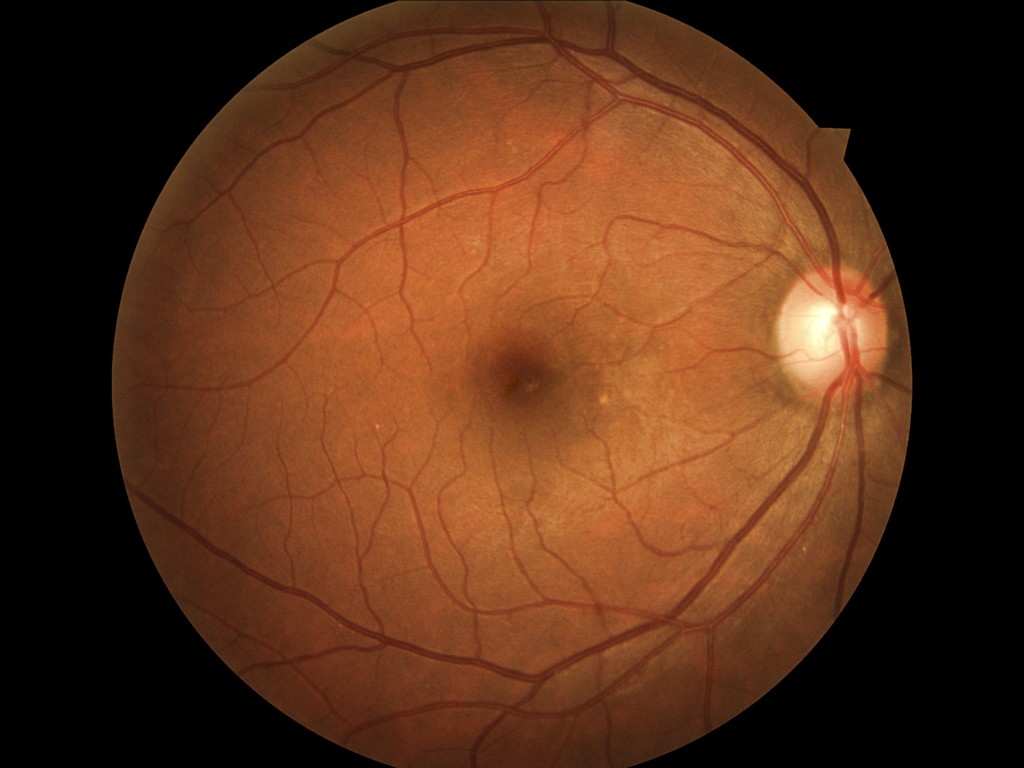

In [ ]:
# ================= #
# Imagen de ejemplo #
# ================= #

img_size = (240,240)

preprocess_input = keras.applications.resnet50.preprocess_input
# decode_predictions = keras.applications.xception.decode_predictions

# The local path to our target image
img_path = path_base + '/train/13_right.jpeg'

display(Image(img_path))

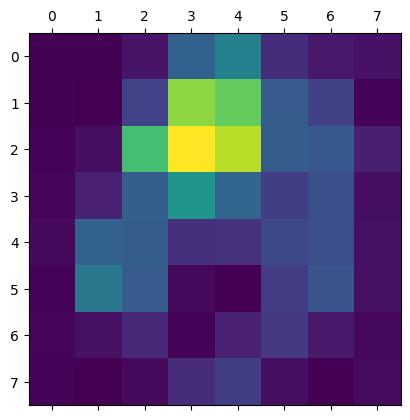

In [ ]:

# Muestra el gradiente-filtro #
model = model_rn50

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# print(model.layers[-1].name)

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
# preds = model.predict(img_array)
# print("Predicted:", preds[0])

# res = model.get_layer("resnet50")
last_conv_layer_name = "conv5_block3_out"
# print(last_conv_layer_name.name)
# last_conv_layer_name = "global_average_pooling2d_1"

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

<ipython-input-24-3846933c6a18>:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


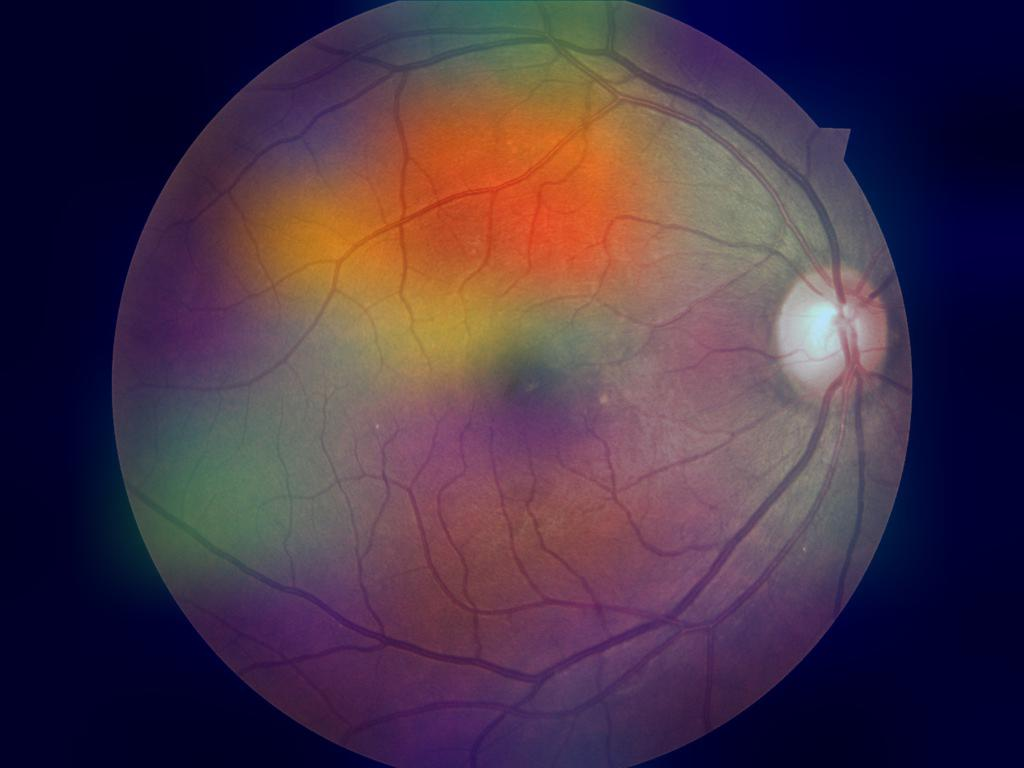

In [ ]:
save_and_display_gradcam(img_path, heatmap)

## MATRIZ CONFUSION

In [ ]:
y_train_pred = model_rn50_data_aug_class_weights_resolution.predict(Xy_train_preprocessed)
y_val_pred = model_rn50_data_aug_class_weights_resolution.predict(Xy_val_preprocessed)

train_size = 28100

def get_labels(element):
    data = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'image_name': tf.io.FixedLenFeature([], tf.string),
        'eye': tf.io.FixedLenFeature([], tf.int64),
        'level_cat': tf.io.FixedLenFeature([], tf.int64),
    }
    content = tf.io.parse_single_example(element, data)
    image = tf.io.decode_jpeg(content['image'], channels=3)
    image = tf.image.resize(image, image_size)
    return content['level_cat']

dataset = tf.data.TFRecordDataset(paths_completos)
labels = dataset.map(get_labels)

y_train = labels.take(train_size)
y_val = labels.skip(train_size)


import numpy as np
from sklearn.metrics import confusion_matrix

# Convert predicted probabilities to discrete labels
y_train_pred_discrete = np.argmax(y_train_pred, axis=1)
y_val_pred_discrete = np.argmax(y_val_pred, axis=1)

# Convert true labels to NumPy array
y_train_true = np.array(list(y_train.as_numpy_iterator()))
y_val_true = np.array(list(y_val.as_numpy_iterator()))

# Calculate confusion matrix
train_cm = confusion_matrix(y_train_true, y_train_pred_discrete)
val_cm = confusion_matrix(y_val_true, y_val_pred_discrete)

220/220 [==============================] - 339s 835ms/step


##TEST

In [ ]:
from natsort import natsorted
import pandas as pd

# Directorio de las imágenes
image_directory = '/content/drive/MyDrive/FACULTAD/TAA/test'

In [ ]:
carpeta = '/content/drive/MyDrive/FACULTAD/TAA/test'
# Obtener la lista de archivos en la carpeta
archivos = os.listdir(carpeta)

# Contar la cantidad de archivos
cantidad_archivos = len(archivos)
cantidad_archivos

53576

In [ ]:
# Se crea el dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
    image_directory,
    labels=None,
    class_names=None,
    batch_size=32,
    image_size=(500, 500),
    shuffle=False,
    )

Found 53576 files belonging to 1 classes.


In [ ]:
#se aplica el mismo preprocesamiento que al entrenar
test_preprocessed = test_dataset.map(lambda X: (keras.applications.resnet50.preprocess_input(X)))

# infiero
y_test =  model_rn50_data_aug_class_weights_resolution.predict(test_preprocessed)

 263/1675 [===>..........................] - ETA: 1:27:13

In [ ]:
#paso los vectores que predije a valores numericos
y_test_lista = np.argmax(y_test, axis=1)
print(y_test_lista)
print(y_test_lista.shape)

lista_imagenes = natsorted(os.listdir(image_directory))
nombres_imagenes = [x.split('.')[0] for x in lista_imagenes]
print(nombres_imagenes)
print(np.shape(nombres_imagenes))
# Crear un DataFrame con los nombres de las imágenes y las predicciones
results = pd.DataFrame({'image': nombres_imagenes, 'level': y_test_lista})

# Generar un archivo CSV con los resultados
results.to_csv('primera_submission_natsorted.csv', index=False)

In [ ]:
import csv

with open('predictions.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['image', 'level'])

    for i, (images, _) in enumerate(test_dataset):
        batch_predictions = y_test[i]
        for j, image in enumerate(images):
            image_name = test_dataset.file_paths[i * test_dataset.batch_size + j]
            prediction = batch_predictions[j]
            writer.writerow([image_name, prediction])